In [1]:
import models
import matplotlib
import matplotlib.pyplot as plt
from sklearn import mixture, preprocessing, datasets
import torch
import torch.nn as nn
import torch.utils.data as data_utils
import torch.nn.functional as F
import torch.optim as optim
import traintest as tt
from copy import deepcopy

import numpy as np
%load_ext autoreload
%autoreload 2

## Quantized Data for CCUq

In [2]:
moons_data, moons_label = datasets.make_moons(n_samples=1000, shuffle=True, noise=.15)

data = (torch.tensor(moons_data, dtype=torch.float16, device='cuda') + 1.6) / 4
label = torch.tensor(moons_label, dtype=torch.float)
label = label.type(torch.LongTensor)

train = data_utils.TensorDataset(data, label)
train_loader = data_utils.DataLoader(train, batch_size=250, shuffle=True)

data_out = torch.rand(1000, 2, dtype=torch.float16)
label_out = torch.zeros(1000)
label_out = label_out.type(torch.LongTensor)

train_out = data_utils.TensorDataset(data_out, label_out)
train_loader_out = data_utils.DataLoader(train_out, batch_size=250, shuffle=True)
tmp = deepcopy(data[:10])

In [3]:
class TwoMoonsNet(nn.Module):
    def __init__(self, dtype = torch.float16):
        super().__init__()
        self.fc1 = nn.Linear(2, 32, dtype=dtype)
        self.fc2 = nn.Linear(32, 64, dtype=dtype)
        self.fc3 = nn.Linear(64, 2, dtype=dtype)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)
device=torch.device('cuda:0')

In [4]:
gmm = models.GMM(50 ,2,quantized=True)
gmm.to('cuda')
gmm.find_solution(data.to('cuda'),iterate=True)

C:\Users\samle\.conda\envs\CCU\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\samle\.conda\envs\CCU\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


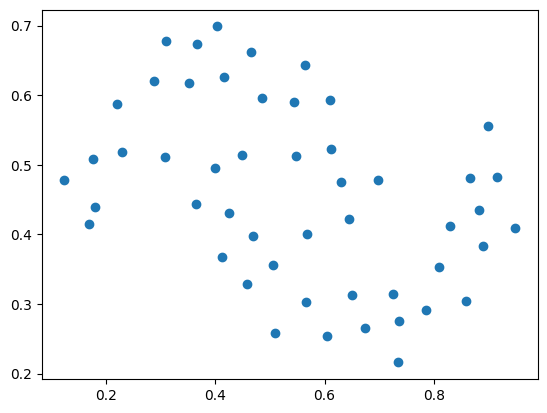

In [5]:
plt.scatter(gmm.mu[:,0].detach().cpu(), gmm.mu[:,1].detach().cpu())

In [6]:
gmm_out = models.GMM(50,2,quantized=True)
gmm_out.find_solution(data_out.to(device), iterate=True)

C:\Users\samle\.conda\envs\CCU\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\samle\.conda\envs\CCU\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


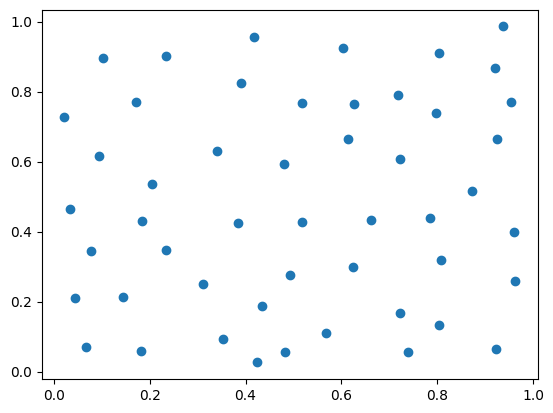

In [7]:
plt.scatter(gmm_out.mu[:,0].detach().cpu(), gmm_out.mu[:,1].detach().cpu());

In [8]:
lr = 0.1
lr_gmm = 1e-3
decay = 5e-4

net = TwoMoonsNet()
param_groups = [{'params':net.parameters(),'lr':lr, 'weight_decay':decay}]

optimizer = optim.SGD(param_groups)

for epoch in range(1000):
     tt.train_plain(net.to(device), device, train_loader, optimizer, 
                    epoch, verbose=-1, noise_loader=iter(train_loader_out),
                   )
model = models.DoublyRobustModel(net,
                                 deepcopy(gmm.to(device)),
                                 deepcopy(gmm_out.to(device)),
                                 0.,
                                 dim=2,
                                 classes=2,
                                quantization=True).to(device)
base_model = TwoMoonsNet().to(device)

In [9]:
net(tmp).dtype

torch.float16

In [10]:
gmm(tmp).dtype

torch.float16

In [11]:
gmm_out(tmp).dtype

torch.float16

In [12]:
model(tmp).dtype

torch.float16

In [13]:
lr = 0.1
lr_gmm = 1e-3
decay = 5e-4


param_groups = [{'params':base_model.parameters(),'lr':lr, 'weight_decay':decay}]

optimizer = optim.SGD(param_groups)

for epoch in range(1000):
     tt.train_plain(base_model.to(device), device, train_loader, optimizer, 
                    epoch, verbose=-1, noise_loader=iter(train_loader_out),
                   )

In [14]:
param_groups = [#{'params':model.mm.parameters(),'lr':lr_gmm, 'weight_decay':0.},
             #   {'params':model.mm_out.parameters(),'lr':lr_gmm, 'weight_decay':0.},
                {'params':model.base_model.parameters(),'lr':lr, 'weight_decay':decay}]

optimizer = optim.SGD(param_groups)

for epoch in range(500):
    tt.train_CEDA_gmm_out(model, device, train_loader, optimizer, 
                          epoch, verbose=1, noise_loader=iter(train_loader_out),
                          dtype=torch.float16)

Train Epoch: 0 [905/1000 (90%)]	Loss: 0.671143
Train Epoch: 1 [910/1000 (91%)]	Loss: 0.759766
Train Epoch: 2 [908/1000 (91%)]	Loss: 0.753662
Train Epoch: 3 [906/1000 (91%)]	Loss: 0.754150
Train Epoch: 4 [908/1000 (91%)]	Loss: 0.754883
Train Epoch: 5 [905/1000 (90%)]	Loss: 0.755127
Train Epoch: 6 [905/1000 (90%)]	Loss: 0.754150
Train Epoch: 7 [911/1000 (91%)]	Loss: 0.752686
Train Epoch: 8 [912/1000 (91%)]	Loss: 0.753906
Train Epoch: 9 [907/1000 (91%)]	Loss: 0.755859
Train Epoch: 10 [908/1000 (91%)]	Loss: 0.757812
Train Epoch: 11 [910/1000 (91%)]	Loss: 0.749512
Train Epoch: 12 [909/1000 (91%)]	Loss: 0.750244
Train Epoch: 13 [913/1000 (91%)]	Loss: 0.751221
Train Epoch: 14 [908/1000 (91%)]	Loss: 0.750977
Train Epoch: 15 [910/1000 (91%)]	Loss: 0.750244
Train Epoch: 16 [909/1000 (91%)]	Loss: 0.749756
Train Epoch: 17 [908/1000 (91%)]	Loss: 0.749268
Train Epoch: 18 [914/1000 (91%)]	Loss: 0.747559
Train Epoch: 19 [908/1000 (91%)]	Loss: 0.750977
Train Epoch: 20 [912/1000 (91%)]	Loss: 0.749023
Tr

In [15]:
model(tmp).dtype

torch.float16

In [16]:
def cross_over(y, x, model):
    data = torch.tensor([[x, y]],dtype=torch.float16, device=device)
    out = model(data).detach().cpu()
    return out[0,0]-out[0,1]
import scipy
model.to(device)
base_model.to(device)

TwoMoonsNet(
  (fc1): Linear(in_features=2, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=2, bias=True)
)

In [17]:
model.to(device)
base_model.to(device)

TwoMoonsNet(
  (fc1): Linear(in_features=2, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=2, bias=True)
)

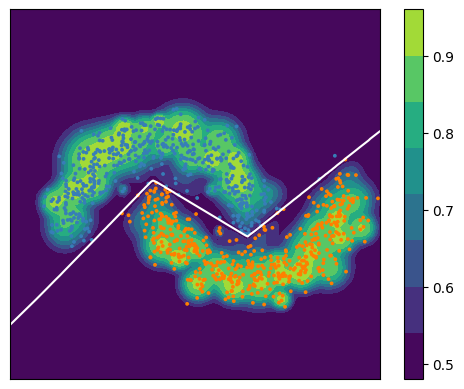

In [18]:
f = plt.figure()
x = np.arange(0., 1.01, 0.01)
y = np.arange(0., 1.01, 0.01)

points = []
for xx in x:
    for yy in y:
        points.append((xx, yy))
colors = np.array(['#377eb8', '#ff7f00', '#4daf4a',
                   '#f781bf', '#a65628', '#984ea3',
                   '#999999', '#e41a1c', '#dede00'])
output = model(torch.tensor(points, dtype=torch.float16, device=device)).detach()
output_data = model(data).detach().cpu()
pred = output.max(1)[0].exp()
z = pred.view(len(x), len(y)).detach().t().cpu().numpy()

output_base = model.base_model(torch.tensor(points, dtype=torch.float16, device=device)).detach()
pred = output_base.max(1)[0].exp()
z_base = pred.view(len(x), len(y)).detach().t().cpu().numpy()

ax = plt.gca()
ax.cla()

plt.contourf(x,y,z, vmin=.5, vmax=1., extend='neither')

norm2 = matplotlib.colors.Normalize(vmin=0.5, vmax=.6, clip=True)
cb = plt.colorbar(ticks=np.linspace(.5,1.,6))


# h = ax.contour(x,y,np.log(z_base-.5002)**3)


ax.scatter(data[:, 0].cpu(), data[:, 1].cpu(), s=3, color=colors[output_data.max(1)[1]])
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xticks([])
plt.yticks([])

dec_x = np.linspace(0,1,200)
dec_y = [scipy.optimize.brentq(cross_over, -0.1, 1.1, 
                               args = (xx, model.base_model)) for xx in dec_x]
plt.plot(dec_x, dec_y, color='white')

plt.gca().set_aspect('equal', adjustable='box')

plt.show()

### Now with PCA Metric

In [19]:
metric = models.PCAMetric(data.to('cpu'), p=2, min_sv_factor=1e6, dtype=torch.float16)
X = ((data@metric.comp_vecs.t()) / metric.singular_values_sqrt[None,:])

In [20]:
clf = mixture.GaussianMixture(n_components=50, 
                              covariance_type='spherical',
                              max_iter=500,
                              n_init=50)
clf.fit(X.cpu())

mu = clf.means_
std = np.sqrt(clf.covariances_)

mu = torch.tensor(clf.means_ ,dtype=torch.float16)
logvar = torch.tensor(np.log(clf.covariances_) ,dtype=torch.float16)
alpha = torch.tensor(np.log(clf.weights_), dtype=torch.float16)
gmm = models.GMM(50, 2, mu=mu, logvar=logvar, alpha=alpha, metric=metric, quantized=True);

C:\Users\samle\.conda\envs\CCU\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\samle\.conda\envs\CCU\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\samle\.conda\envs\CCU\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\samle\.conda\envs\CCU\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have

In [21]:
data_out = data_out.to('cuda')

In [22]:
metric2 = models.PCAMetric(data_out.cpu(), p=2, min_sv_factor=1e6, dtype=torch.float16)
X2 = ((data_out@metric2.comp_vecs.t()) / metric2.singular_values_sqrt[None,:])

In [23]:
clf = mixture.GaussianMixture(n_components=50, 
                              covariance_type='spherical',
                              max_iter=500,
                              n_init=50)
clf.fit(X2.cpu())

mu = clf.means_
std = np.sqrt(clf.covariances_)

mu = torch.tensor(clf.means_ ,dtype=torch.float16)
logvar = torch.tensor(np.log(clf.covariances_) ,dtype=torch.float16)
alpha = torch.tensor(np.log(clf.weights_), dtype=torch.float16)
gmm_out = models.GMM(50, 2, mu=mu, logvar=logvar, alpha=alpha, metric=metric2, quantized=True);

C:\Users\samle\.conda\envs\CCU\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\samle\.conda\envs\CCU\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\samle\.conda\envs\CCU\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\samle\.conda\envs\CCU\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have

In [24]:
lr = 0.1
lr_gmm = 1e-3
decay = 5e-4
net = TwoMoonsNet()
param_groups = [{'params':net.parameters(),'lr':lr, 'weight_decay':decay}]

optimizer = optim.SGD(param_groups)
for epoch in range(1000):
     tt.train_plain(net.to(device), device, train_loader, optimizer, 
                    epoch, verbose=50, noise_loader=iter(train_loader_out),
                   )
model = models.DoublyRobustModel(net,
                                 deepcopy(gmm.to(device)),
                                 deepcopy(gmm_out.to(device)),
                                 0.,
                                 dim=2,
                                 classes=2,
                                quantization=True).to(device)
base_model = TwoMoonsNet().to(device)

Train Epoch: 0 [500/1000 (50%)]	Loss: 1.389648
Train Epoch: 1 [500/1000 (50%)]	Loss: 1.385010
Train Epoch: 2 [500/1000 (50%)]	Loss: 1.381104
Train Epoch: 3 [500/1000 (50%)]	Loss: 1.377686
Train Epoch: 4 [536/1000 (54%)]	Loss: 1.374512
Train Epoch: 5 [601/1000 (60%)]	Loss: 1.370605
Train Epoch: 6 [699/1000 (70%)]	Loss: 1.367188
Train Epoch: 7 [695/1000 (70%)]	Loss: 1.363281
Train Epoch: 8 [720/1000 (72%)]	Loss: 1.359375
Train Epoch: 9 [712/1000 (71%)]	Loss: 1.355713
Train Epoch: 10 [718/1000 (72%)]	Loss: 1.351318
Train Epoch: 11 [718/1000 (72%)]	Loss: 1.347412
Train Epoch: 12 [710/1000 (71%)]	Loss: 1.343506
Train Epoch: 13 [725/1000 (72%)]	Loss: 1.339111
Train Epoch: 14 [720/1000 (72%)]	Loss: 1.334961
Train Epoch: 15 [720/1000 (72%)]	Loss: 1.330078
Train Epoch: 16 [716/1000 (72%)]	Loss: 1.325439
Train Epoch: 17 [714/1000 (71%)]	Loss: 1.321045
Train Epoch: 18 [722/1000 (72%)]	Loss: 1.315674
Train Epoch: 19 [725/1000 (72%)]	Loss: 1.310059
Train Epoch: 20 [727/1000 (73%)]	Loss: 1.304932
Tr

In [25]:
param_groups = [{'params':base_model.parameters(),'lr':lr, 'weight_decay':decay}]

optimizer = optim.SGD(param_groups)

for epoch in range(1000):
     tt.train_plain(base_model.to(device), device, train_loader, optimizer, 
                    epoch, verbose=50, noise_loader=iter(train_loader_out),
                   )

Train Epoch: 0 [500/1000 (50%)]	Loss: 1.378906
Train Epoch: 1 [579/1000 (58%)]	Loss: 1.368408
Train Epoch: 2 [829/1000 (83%)]	Loss: 1.360840
Train Epoch: 3 [831/1000 (83%)]	Loss: 1.353027
Train Epoch: 4 [763/1000 (76%)]	Loss: 1.346191
Train Epoch: 5 [747/1000 (75%)]	Loss: 1.340088
Train Epoch: 6 [765/1000 (76%)]	Loss: 1.333740
Train Epoch: 7 [754/1000 (75%)]	Loss: 1.327637
Train Epoch: 8 [784/1000 (78%)]	Loss: 1.320557
Train Epoch: 9 [768/1000 (77%)]	Loss: 1.313477
Train Epoch: 10 [781/1000 (78%)]	Loss: 1.306885
Train Epoch: 11 [770/1000 (77%)]	Loss: 1.300049
Train Epoch: 12 [807/1000 (81%)]	Loss: 1.292236
Train Epoch: 13 [812/1000 (81%)]	Loss: 1.284668
Train Epoch: 14 [826/1000 (83%)]	Loss: 1.276611
Train Epoch: 15 [824/1000 (82%)]	Loss: 1.268311
Train Epoch: 16 [827/1000 (83%)]	Loss: 1.259521
Train Epoch: 17 [834/1000 (83%)]	Loss: 1.250488
Train Epoch: 18 [831/1000 (83%)]	Loss: 1.241455
Train Epoch: 19 [828/1000 (83%)]	Loss: 1.231445
Train Epoch: 20 [832/1000 (83%)]	Loss: 1.220947
Tr

In [26]:
lr = 0.1
lr_gmm = 1e-3
decay = 5e-4

param_groups = [#{'params':model.mm.parameters(),'lr':lr_gmm, 'weight_decay':0.},
                #{'params':model.mm_out.parameters(),'lr':lr_gmm, 'weight_decay':0.},
                {'params':model.base_model.parameters(),'lr':lr, 'weight_decay':decay}]

optimizer = optim.SGD(param_groups)

for epoch in range(40):
    tt.train_CEDA_gmm_out(model, device, train_loader, optimizer, 
                          epoch, verbose=1, noise_loader=iter(train_loader_out),
                          dtype=torch.float16)

Train Epoch: 0 [500/1000 (50%)]	Loss: 128.062500
Train Epoch: 1 [500/1000 (50%)]	Loss: 94.156250
Train Epoch: 2 [500/1000 (50%)]	Loss: 94.156250
Train Epoch: 3 [500/1000 (50%)]	Loss: 94.171875
Train Epoch: 4 [500/1000 (50%)]	Loss: 94.187500
Train Epoch: 5 [500/1000 (50%)]	Loss: 94.171875
Train Epoch: 6 [500/1000 (50%)]	Loss: 94.140625
Train Epoch: 7 [500/1000 (50%)]	Loss: 94.171875
Train Epoch: 8 [500/1000 (50%)]	Loss: 94.171875
Train Epoch: 9 [500/1000 (50%)]	Loss: 94.140625
Train Epoch: 10 [500/1000 (50%)]	Loss: 94.140625
Train Epoch: 11 [500/1000 (50%)]	Loss: 94.187500
Train Epoch: 12 [500/1000 (50%)]	Loss: 94.156250
Train Epoch: 13 [500/1000 (50%)]	Loss: 94.156250
Train Epoch: 14 [500/1000 (50%)]	Loss: 94.156250
Train Epoch: 15 [500/1000 (50%)]	Loss: 94.187500
Train Epoch: 16 [500/1000 (50%)]	Loss: 94.156250
Train Epoch: 17 [500/1000 (50%)]	Loss: 94.171875
Train Epoch: 18 [500/1000 (50%)]	Loss: 94.171875
Train Epoch: 19 [500/1000 (50%)]	Loss: 94.187500
Train Epoch: 20 [500/1000 (50

In [27]:
model(tmp)

tensor([[-0.6875, -0.6875],
        [-0.6875, -0.6875],
        [-0.6875, -0.6875],
        [-0.6875, -0.6875],
        [-0.6914, -0.6914],
        [-0.6953, -0.6953],
        [-0.6953, -0.6953],
        [-0.6875, -0.6875],
        [-0.6953, -0.6953],
        [-0.6875, -0.6875]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SubBackward0>)

Not Converging with PCA --- KNOWN ISSUE

### Non-Quantized for Reference

In [28]:
moons_data, moons_label = datasets.make_moons(n_samples=1000, shuffle=True, noise=.15)

data = (torch.tensor(moons_data, dtype=torch.float,) + 1.6) / 4
label = torch.tensor(moons_label, dtype=torch.float)
label = label.type(torch.LongTensor)

train = data_utils.TensorDataset(data, label)
train_loader = data_utils.DataLoader(train, batch_size=250, shuffle=True)

data_out = torch.rand(1000, 2, dtype=torch.float)
label_out = torch.zeros(1000)
label_out = label_out.type(torch.LongTensor)

train_out = data_utils.TensorDataset(data_out, label_out)
train_loader_out = data_utils.DataLoader(train_out, batch_size=250, shuffle=True)
tmp = deepcopy(data[:10])

In [29]:
gmm = models.GMM(50 ,2,quantized=False)
gmm.find_solution(data.cpu(),iterate=True)

gmm_out = models.GMM(50,2,quantized=False)
gmm_out.find_solution(data_out.cpu(), iterate=True)

net = TwoMoonsNet(dtype=torch.float)


# param_groups = [{'params':net.parameters(),'lr':lr, 'weight_decay':decay}]

# optimizer = optim.SGD(param_groups)

# for epoch in range(100):
#      tt.train_plain(net.to(device), device, train_loader, optimizer, 
#                     epoch, verbose=-1, noise_loader=iter(train_loader_out),
#                    )
        
model = models.DoublyRobustModel(net,
                                 deepcopy(gmm.to(device)),
                                 deepcopy(gmm_out.to(device)),
                                 0.,
                                 dim=2,
                                 classes=2,
                                quantization=False).to(device)
base_model = TwoMoonsNet(dtype=torch.float).to(device)

C:\Users\samle\.conda\envs\CCU\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\samle\.conda\envs\CCU\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\samle\.conda\envs\CCU\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\samle\.conda\envs\CCU\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it 

In [30]:
lr = 0.1
lr_gmm = 1e-5
decay = 5e-4

param_groups = [{'params':model.mm.parameters(),'lr':lr_gmm, 'weight_decay':0.},
             #   {'params':model.mm_out.parameters(),'lr':lr_gmm, 'weight_decay':0.},
                {'params':model.base_model.parameters(),'lr':lr, 'weight_decay':0}]

optimizer = optim.SGD(param_groups)

for epoch in range(1200):
    tt.train_CEDA_gmm_out(model, device, train_loader, optimizer, 
                          epoch, verbose=1, noise_loader=iter(train_loader_out),
                          dtype=torch.float)

Train Epoch: 0 [500/1000 (50%)]	Loss: 1.607489
Train Epoch: 1 [681/1000 (68%)]	Loss: 1.731919
Train Epoch: 2 [764/1000 (76%)]	Loss: 1.726815
Train Epoch: 3 [756/1000 (76%)]	Loss: 1.722965
Train Epoch: 4 [757/1000 (76%)]	Loss: 1.719098
Train Epoch: 5 [748/1000 (75%)]	Loss: 1.715237
Train Epoch: 6 [745/1000 (74%)]	Loss: 1.712363
Train Epoch: 7 [726/1000 (73%)]	Loss: 1.708537
Train Epoch: 8 [742/1000 (74%)]	Loss: 1.705113
Train Epoch: 9 [755/1000 (76%)]	Loss: 1.701514
Train Epoch: 10 [768/1000 (77%)]	Loss: 1.698127
Train Epoch: 11 [766/1000 (77%)]	Loss: 1.694380
Train Epoch: 12 [751/1000 (75%)]	Loss: 1.690633
Train Epoch: 13 [785/1000 (78%)]	Loss: 1.686442
Train Epoch: 14 [788/1000 (79%)]	Loss: 1.682519
Train Epoch: 15 [799/1000 (80%)]	Loss: 1.677967
Train Epoch: 16 [795/1000 (80%)]	Loss: 1.673675
Train Epoch: 17 [795/1000 (80%)]	Loss: 1.668842
Train Epoch: 18 [799/1000 (80%)]	Loss: 1.664258
Train Epoch: 19 [793/1000 (79%)]	Loss: 1.659453
Train Epoch: 20 [805/1000 (80%)]	Loss: 1.654019
Tr

In [31]:
def cross_over(y, x, model):
    data2 = torch.tensor([[x, y]],dtype=torch.float)
    out = model(data2).detach().cpu()
    return out[0,0]-out[0,1]

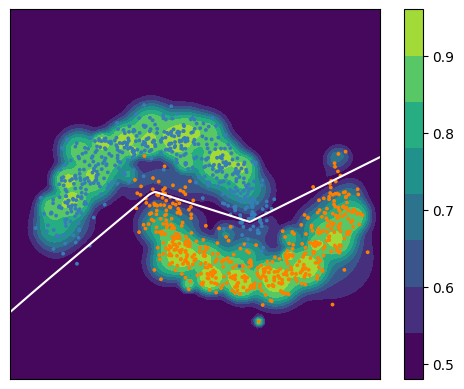

In [32]:
f = plt.figure()

output = model.cpu()(torch.tensor(points, dtype=torch.float)).detach()
output_data =  model.cpu()(data.cpu()).detach().cpu()
pred = output.max(1)[0].exp()
z = pred.view(len(x), len(y)).detach().t().cpu().numpy()

output_base = model.base_model(torch.tensor(points, dtype=torch.float)).detach()
pred = output_base.max(1)[0].exp()
z_base = pred.view(len(x), len(y)).detach().t().cpu().numpy()

ax = plt.gca()
ax.cla()

plt.contourf(x,y,z, vmin=.5, vmax=1., extend='neither')

norm2 = matplotlib.colors.Normalize(vmin=0.5, vmax=1, clip=True)
cb = plt.colorbar(ticks=np.linspace(.5,1.,6))


# h = ax.contour(x,y,np.log(z_base-.5002)**3)


ax.scatter(data[:, 0].cpu(), data[:, 1].cpu(), s=3, color=colors[label])
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xticks([])
plt.yticks([])

dec_x = np.linspace(0,1,200)
dec_y = [scipy.optimize.brentq(cross_over, -0.1, 1.1, 
                               args = (xx, model.base_model.cpu())) for xx in dec_x]
plt.plot(dec_x, dec_y, color='white')

plt.gca().set_aspect('equal', adjustable='box')

plt.show()

## Using Metric

In [33]:
metric = models.PCAMetric(data.to('cpu'), p=2, min_sv_factor=1e6, dtype=torch.float)
X = ((data@metric.cpu().comp_vecs.t()) / metric.cpu().singular_values_sqrt[None,:])

metric2 = models.PCAMetric(data_out.cpu(), p=2, min_sv_factor=1e6, dtype=torch.float)
X2 = ((data_out@metric2.cpu().comp_vecs.t()) / metric2.cpu().singular_values_sqrt[None,:])

In [34]:
clf = mixture.GaussianMixture(n_components=50, 
                              covariance_type='spherical',
                              max_iter=500,
                              n_init=50)
clf.fit(X.cpu())

mu = clf.means_
std = np.sqrt(clf.covariances_)

mu = torch.tensor(clf.means_ ,dtype=torch.float)
logvar = torch.tensor(np.log(clf.covariances_) ,dtype=torch.float)
alpha = torch.tensor(np.log(clf.weights_), dtype=torch.float)
gmm = models.GMM(50, 2, mu=mu, logvar=logvar, alpha=alpha, metric=metric, quantized=False);

C:\Users\samle\.conda\envs\CCU\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\samle\.conda\envs\CCU\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\samle\.conda\envs\CCU\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\samle\.conda\envs\CCU\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have

In [35]:
clf = mixture.GaussianMixture(n_components=50, 
                              covariance_type='spherical',
                              max_iter=500,
                              n_init=50)
clf.fit(X2.cpu())

mu = clf.means_
std = np.sqrt(clf.covariances_)

mu = torch.tensor(clf.means_ ,dtype=torch.float)
logvar = torch.tensor(np.log(clf.covariances_) ,dtype=torch.float)
alpha = torch.tensor(np.log(clf.weights_), dtype=torch.float)
gmm_out = models.GMM(50, 2, mu=mu, logvar=logvar, alpha=alpha, metric=metric2, quantized=False);

C:\Users\samle\.conda\envs\CCU\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\samle\.conda\envs\CCU\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\samle\.conda\envs\CCU\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\samle\.conda\envs\CCU\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have

In [36]:
net = TwoMoonsNet(dtype=torch.float)
param_groups = [{'params':net.parameters(),'lr':lr, 'weight_decay':decay}]

optimizer = optim.SGD(param_groups)

for epoch in range(200):
     tt.train_plain(net.to(device), device, train_loader, optimizer, 
                    epoch, verbose=50, noise_loader=iter(train_loader_out),
                   )
model = models.DoublyRobustModel(net,
                                 deepcopy(gmm.to(device)),
                                 deepcopy(gmm_out.to(device)),
                                 0.,
                                 dim=2,
                                 classes=2,
                                quantization=False).to(device)
base_model = TwoMoonsNet(dtype=torch.float).to(device)

Train Epoch: 0 [500/1000 (50%)]	Loss: 1.412379
Train Epoch: 1 [500/1000 (50%)]	Loss: 1.397728
Train Epoch: 2 [500/1000 (50%)]	Loss: 1.385758
Train Epoch: 3 [500/1000 (50%)]	Loss: 1.376115
Train Epoch: 4 [500/1000 (50%)]	Loss: 1.367646
Train Epoch: 5 [500/1000 (50%)]	Loss: 1.359886
Train Epoch: 6 [535/1000 (54%)]	Loss: 1.352103
Train Epoch: 7 [653/1000 (65%)]	Loss: 1.344187
Train Epoch: 8 [774/1000 (77%)]	Loss: 1.336582
Train Epoch: 9 [792/1000 (79%)]	Loss: 1.328798
Train Epoch: 10 [798/1000 (80%)]	Loss: 1.321467
Train Epoch: 11 [797/1000 (80%)]	Loss: 1.312701
Train Epoch: 12 [800/1000 (80%)]	Loss: 1.304043
Train Epoch: 13 [797/1000 (80%)]	Loss: 1.295234
Train Epoch: 14 [797/1000 (80%)]	Loss: 1.285706
Train Epoch: 15 [796/1000 (80%)]	Loss: 1.275750
Train Epoch: 16 [800/1000 (80%)]	Loss: 1.265455
Train Epoch: 17 [800/1000 (80%)]	Loss: 1.254416
Train Epoch: 18 [799/1000 (80%)]	Loss: 1.242722
Train Epoch: 19 [804/1000 (80%)]	Loss: 1.230544
Train Epoch: 20 [808/1000 (81%)]	Loss: 1.217787
Tr

In [37]:
lr = 0.1
lr_gmm = 1e-5
decay = 5e-4


param_groups = [{'params':base_model.parameters(),'lr':lr, 'weight_decay':decay}]

optimizer = optim.SGD(param_groups)

for epoch in range(100):
     tt.train_plain(base_model.to(device), device, train_loader, optimizer, 
                    epoch, verbose=50, noise_loader=iter(train_loader_out),
                   )

param_groups = [{'params':model.mm.parameters(),'lr':lr_gmm, 'weight_decay':0.},
             #   {'params':model.mm_out.parameters(),'lr':lr_gmm, 'weight_decay':0.},
                {'params':model.base_model.parameters(),'lr':lr, 'weight_decay':decay}]

optimizer = optim.SGD(param_groups)

for epoch in range(400):
    tt.train_CEDA_gmm_out(model, device, train_loader, optimizer, 
                          epoch, verbose=1, noise_loader=iter(train_loader_out),
                          dtype=torch.float)

Train Epoch: 0 [500/1000 (50%)]	Loss: 1.384476
Train Epoch: 1 [500/1000 (50%)]	Loss: 1.379743
Train Epoch: 2 [500/1000 (50%)]	Loss: 1.374335
Train Epoch: 3 [500/1000 (50%)]	Loss: 1.369401
Train Epoch: 4 [500/1000 (50%)]	Loss: 1.364495
Train Epoch: 5 [500/1000 (50%)]	Loss: 1.359053
Train Epoch: 6 [649/1000 (65%)]	Loss: 1.353666
Train Epoch: 7 [621/1000 (62%)]	Loss: 1.347901
Train Epoch: 8 [575/1000 (58%)]	Loss: 1.342501
Train Epoch: 9 [814/1000 (81%)]	Loss: 1.335728
Train Epoch: 10 [816/1000 (82%)]	Loss: 1.329533
Train Epoch: 11 [826/1000 (83%)]	Loss: 1.322556
Train Epoch: 12 [829/1000 (83%)]	Loss: 1.315634
Train Epoch: 13 [823/1000 (82%)]	Loss: 1.308370
Train Epoch: 14 [820/1000 (82%)]	Loss: 1.300145
Train Epoch: 15 [823/1000 (82%)]	Loss: 1.291783
Train Epoch: 16 [828/1000 (83%)]	Loss: 1.283322
Train Epoch: 17 [823/1000 (82%)]	Loss: 1.274163
Train Epoch: 18 [820/1000 (82%)]	Loss: 1.264120
Train Epoch: 19 [826/1000 (83%)]	Loss: 1.253971
Train Epoch: 20 [824/1000 (82%)]	Loss: 1.243663
Tr

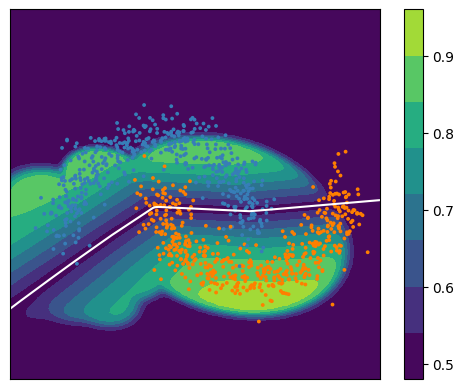

In [38]:
f = plt.figure()

output = model.cpu()(torch.tensor(points, dtype=torch.float)).detach()
output_data =  model.cpu()(data.cpu()).detach().cpu()
pred = output.max(1)[0].exp()
z = pred.view(len(x), len(y)).detach().t().cpu().numpy()

output_base = model.base_model(torch.tensor(points, dtype=torch.float)).detach()
pred = output_base.max(1)[0].exp()
z_base = pred.view(len(x), len(y)).detach().t().cpu().numpy()

ax = plt.gca()
ax.cla()

plt.contourf(x,y,z, vmin=.5, vmax=1., extend='neither')

norm2 = matplotlib.colors.Normalize(vmin=0.5, vmax=1, clip=True)
cb = plt.colorbar(ticks=np.linspace(.5,1.,6))


# h = ax.contour(x,y,np.log(z_base-.5002)**3)


ax.scatter(data[:, 0].cpu(), data[:, 1].cpu(), s=3, color=colors[label])
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xticks([])
plt.yticks([])

dec_x = np.linspace(0,1,200)
dec_y = [scipy.optimize.brentq(cross_over, -0.1, 1.1, 
                               args = (xx, model.base_model.cpu())) for xx in dec_x]
plt.plot(dec_x, dec_y, color='white')

plt.gca().set_aspect('equal', adjustable='box')

plt.show()